<a href="https://colab.research.google.com/github/krwiozerczydzik/INWD/blob/main/INWD_projekt_UrbanPawlewski.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Michał Pawlewski & Wojciech Urban
# **Projekt zaliczeniowy**
## Informatyczne Narzędzia Wizualizacji Danych

## Instalacja i import pakietów

Instalacja oraz importowanie niezbędnych pakietów języka Python. Do tworzenia wykresów zostaną wykorzystane przede wszystkim matplotlib, seaborn oraz geopandas.

In [5]:
!pip install --upgrade geopandas
!pip install matplotlib==3.6.2
!pip install imutils
!pip install poli_sci_kit
!pip install pywaffle

from matplotlib.patches import ConnectionPatch
from imageio import imread
from pywaffle import Waffle
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import geopandas as gpd
import folium
import numpy as np
import webbrowser
import plotly.express as px
import json
import seaborn as sb
import poli_sci_kit

## Podpięcie Dysku Google
Potrzebne pliki z danymi do wykresów znajdują się na dysku Google Michała Pawlewskiego, który jest podpięty bezpośrednio do projektu.

In [6]:
from google.colab import drive
# Podpięcie notatnika do dysku Michała
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Na początek obrabiamy dane z wynikami wyborów do Sejmu RP. Dane są ogólnodostępne, udostępniane przez Państwowy Komitet Wyborczy na swojej stronie internetowej.

In [31]:
wyniki = pd.read_csv('/content/wyniki_gl_na_listy_po_obwodach_sejm.csv', sep=';', dtype={'Kod TERYT': str})
ms_A01_Granice_wojewodztw = gpd.read_file('/content/ms_A01_Granice_wojewodztw.gml',index_col=False)
frekwencja_według_wieku = pd.read_excel('/content/Frekwencja według wieku.xlsx')
gminy = gpd.read_file('/content/gminy/gminy.shp')

# Wczytanie obrazów
kat1 = imread('/content/18-29.png')
kat2 = imread('/content/30-39.png')
kat3 = imread('/content/40-49.png')
kat4 = imread('/content/50-59.png')
kat5 = imread('/content/60-.png')

<ipython-input-31-2af40bb76a2e>:1: DtypeWarning: Columns (10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  wyniki = pd.read_csv('/content/wyniki_gl_na_listy_po_obwodach_sejm.csv', sep=';', dtype={'Kod TERYT': str})
<ipython-input-31-2af40bb76a2e>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  kat1 = imread('/content/18-29.png')
<ipython-input-31-2af40bb76a2e>:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  kat2 = imread('/content/30-39.png')
<ipython-input-31

## Wykres słupkowy frekwencji w województwach

In [8]:
# Obróbka danych na potrzeby wykresu frekwencji w województwach według typów obszaru
wyniki_obszar = wyniki
# Wybranie niezbędnych kolumn
wyniki_obszar = wyniki_obszar[["Kod TERYT",
                               "Liczba wyborców uprawnionych do głosowania",
                               "Liczba wyborców, którym wydano karty do głosowania",
                               "Typ obszaru",
                               "Województwo"
                               ]]
# Nowe przyjemniejsze nazwy dla kolumn
wyniki_obszar.columns = ["teryt", "uprawnieni", "głosy", "typ", "wojewodztwo"]
# Potrzebne są tylko dwie pierwsze cyfry kodu TERYT jako identyfikator województwa
wyniki_obszar["teryt"] = wyniki_obszar["teryt"].str[:2]
# Usunięcie niewygodnych braków danych
wyniki_obszar = wyniki_obszar.replace("NaN", 0).replace("-",0).fillna(0)
# Przekształcenie wartości do wartości numerycznej
wyniki_obszar["uprawnieni"] = pd.to_numeric(wyniki_obszar["uprawnieni"])
wyniki_obszar["głosy"] = pd.to_numeric(wyniki_obszar["głosy"])
# Zsumowanie liczby wyborców według województw i typów obszaru
wyniki_obszar = wyniki_obszar.groupby(["teryt", "typ", "wojewodztwo"]).sum()
# Policzenie frekwencji
wyniki_obszar["frekwencja"] = wyniki_obszar["głosy"]/wyniki_obszar[ "uprawnieni"]
 # Usunięcie obwodów, gdzie nikt nie jest uprawniony do głosowania
wyniki_obszar = wyniki_obszar[wyniki_obszar.uprawnieni != 0]
wyniki_obszar["frekwencja procentowo"] = wyniki_obszar["frekwencja"].map('{:.2%}'.format)
# Zresetowanie indeksu
wyniki_obszar = wyniki_obszar.reset_index()
# Wyrzucenie nieistotnych dla nas wyników dla wyborców zza granicy i na statkach
wyniki_obszar = wyniki_obszar[~wyniki_obszar['typ'].isin(['zagranica', 'statek'])]

wyniki_obszar.head()

<ipython-input-8-125488c1b5ab>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wyniki_obszar["teryt"] = wyniki_obszar["teryt"].str[:2]


,teryt,typ,wojewodztwo,uprawnieni,głosy,frekwencja,frekwencja procentowo
0,02,miasto,dolnośląskie,1566018,986467,0.629921,62.99%
1,02,miasto i wieś,dolnośląskie,14106,7406,0.525025,52.50%
2,02,wieś,dolnośląskie,693617,391557,0.564515,56.45%
3,04,miasto,kujawsko-pomorskie,944612,583596,0.617816,61.78%
4,04,miasto i wieś,kujawsko-pomorskie,1597,966,0.604884,60.49%


*Wykres* słupkowy frekwencji dla poszczególnych województw z podziałem na typ obszaru - miasto, miasto i wieś oraz wieś. Wykres z wykorzystaniem pakietu Seaborn.

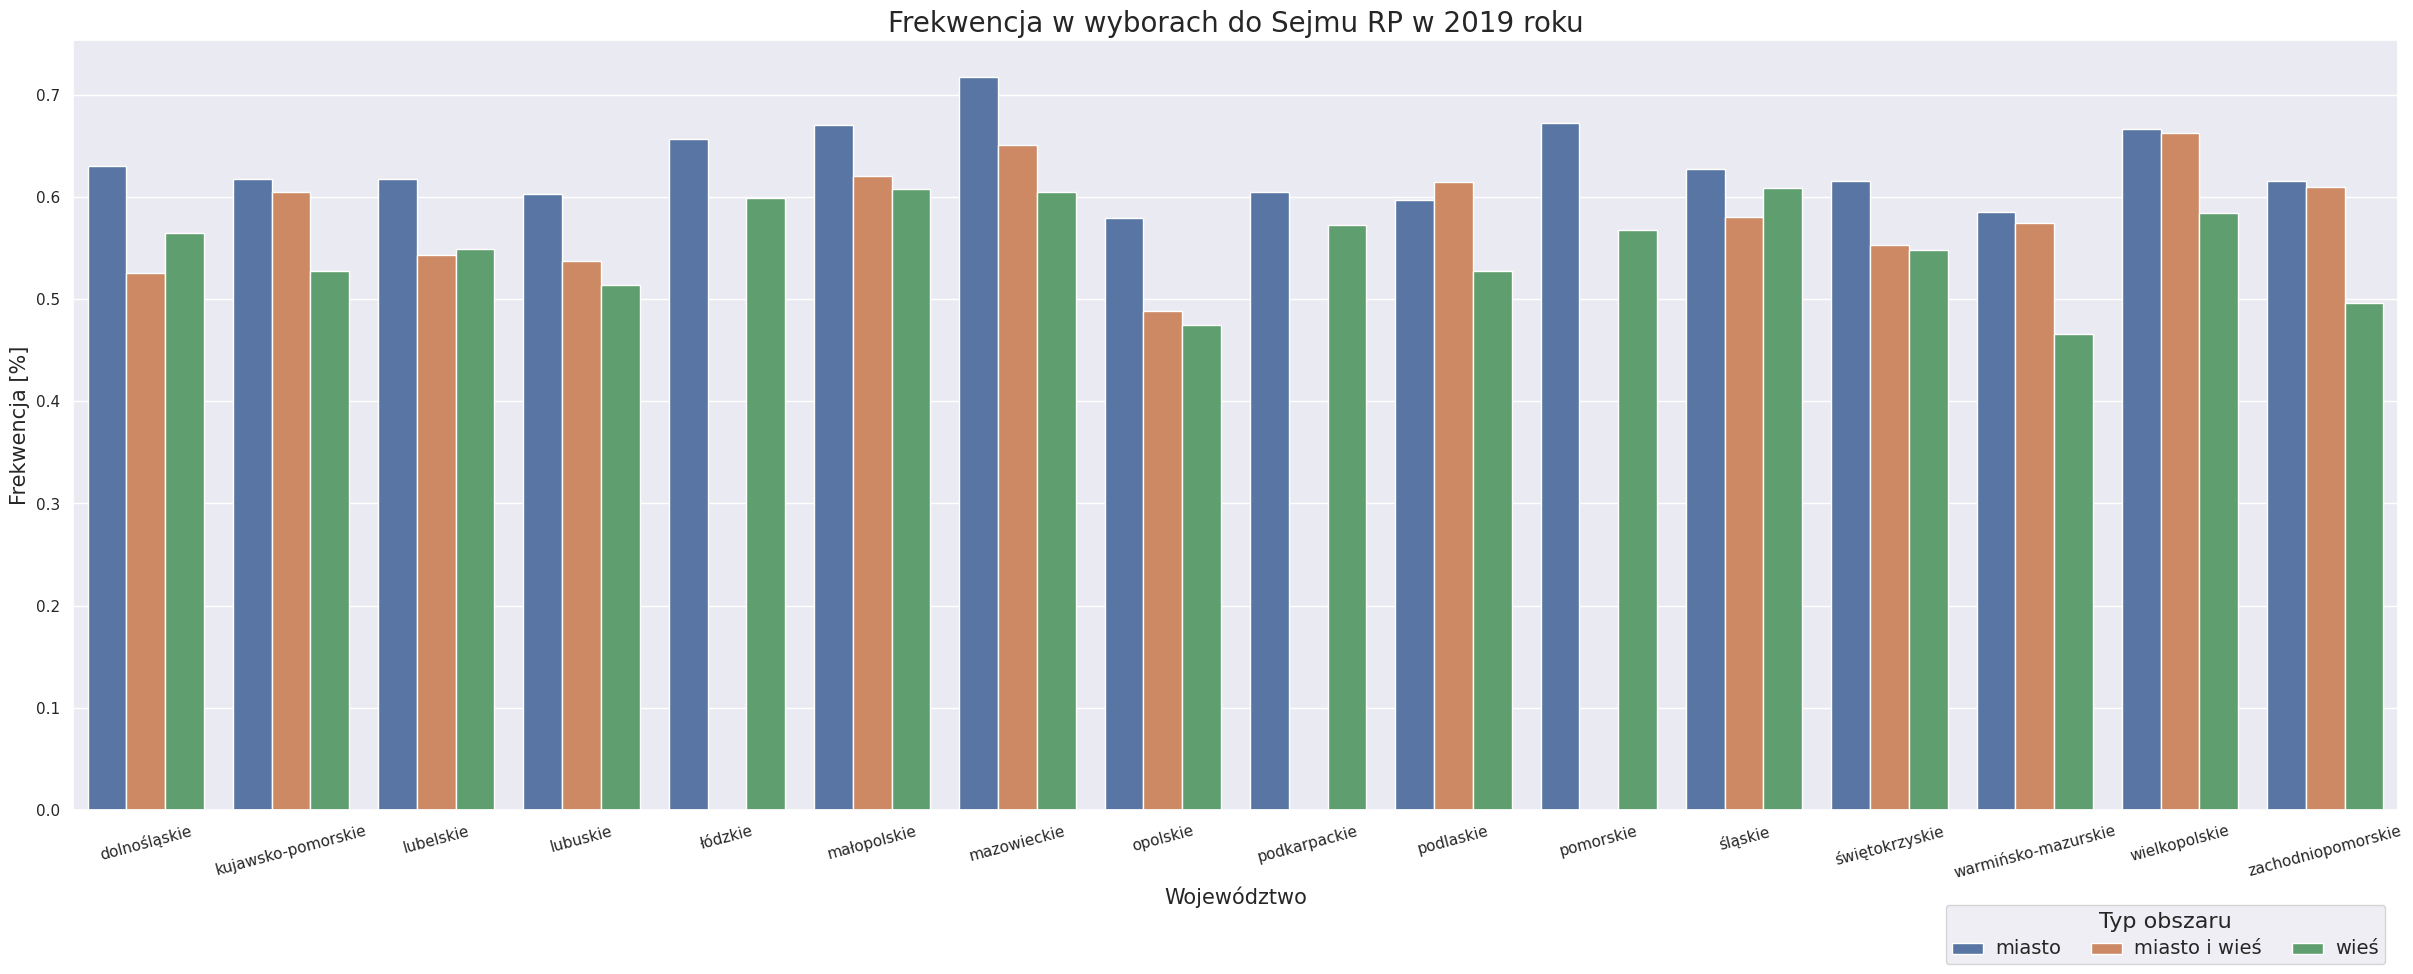

In [9]:
# Utworzenie przestrzeni dla wykresu z dobraną wielkością
sb.set(rc={'figure.figsize':(30,10)})

# Utworzenie wykresu
wykres = sb.barplot(data=wyniki_obszar, x="wojewodztwo", y="frekwencja", hue = "typ")

# Ustawienia legendy
plt.legend(bbox_to_anchor=(.9,-.2), loc='lower center', borderaxespad=0, ncol=3, title = "Typ obszaru")
plt.setp(wykres.get_legend().get_texts(), fontsize='14')
plt.setp(wykres.get_legend().get_title(), fontsize='16')

# Ustawienia opisów osi
wykres.set_title("Frekwencja w wyborach do Sejmu RP w 2019 roku", fontsize = 20)
wykres.set_xlabel("Województwo",fontsize=15)
wykres.set_ylabel("Frekwencja [%]",fontsize=15)

# Przekręcenie nazw województw o 15 stopni
wykres.tick_params(axis='x', rotation=15)



## Wykres mapowy frekwencji w województwach

In [10]:
# Przy obróbce danych do wykresu mapowego
frekwencja_do_mapy = wyniki
frekwencja_do_mapy = frekwencja_do_mapy[["Kod TERYT",
                                 "Liczba wyborców uprawnionych do głosowania",
                                 "Liczba wyborców, którym wydano karty do głosowania",
                                 "Województwo"]]
frekwencja_do_mapy.columns = ["teryt", "uprawnieni", "głosy","wojewodztwo"]
frekwencja_do_mapy["teryt"] = frekwencja_do_mapy["teryt"].str[:2]
frekwencja_do_mapy = frekwencja_do_mapy.replace("NaN", 0).replace("-",0).fillna(0)
frekwencja_do_mapy["uprawnieni"] = pd.to_numeric(frekwencja_do_mapy["uprawnieni"])
frekwencja_do_mapy["głosy"] = pd.to_numeric(frekwencja_do_mapy["głosy"])
frekwencja_do_mapy = frekwencja_do_mapy.groupby("teryt").sum()
frekwencja_do_mapy["frekwencja"] = frekwencja_do_mapy["głosy"]/frekwencja_do_mapy["uprawnieni"]
frekwencja_do_mapy = frekwencja_do_mapy[frekwencja_do_mapy.uprawnieni != 0]
frekwencja_do_mapy["frekwencja procentowo"] = frekwencja_do_mapy["frekwencja"].map('{:.2%}'.format)

frekwencja_do_mapy['wojewodztwo'] = frekwencja_do_mapy.index # dodanie kolumny z numerem województwa
frekwencja_do_mapy["indeks"] = range(1, len(frekwencja_do_mapy)+1) # utworzenie kolumny z indeksem

frekwencja_do_mapy.set_index(frekwencja_do_mapy["indeks"], inplace=True) # indeksowanie po kolejnych liczbach całkowitych
cols = frekwencja_do_mapy.columns.tolist() # utworzenie listy kolumn tabeli
cols = cols[-1:] + cols[:-1] # zamiana kolejności kolumn w tabeli
frekwencja_do_mapy = frekwencja_do_mapy[cols]

del frekwencja_do_mapy["indeks"] # usunięcie zbędnej już kolumny
frekwencja_do_mapy["wojewodztwo"] = pd.to_numeric(frekwencja_do_mapy["wojewodztwo"]) # konwersja kolumny kodu województwa na typ numeryczny (int)


frekwencja_do_mapy # ukazanie tabeli

<ipython-input-10-3c4ed62d025a>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frekwencja_do_mapy["teryt"] = frekwencja_do_mapy["teryt"].str[:2]
<ipython-input-10-3c4ed62d025a>:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  frekwencja_do_mapy = frekwencja_do_mapy.groupby("teryt").sum()


,uprawnieni,głosy,frekwencja,frekwencja procentowo,wojewodztwo
indeks,,,,,
1,2273741,1385430,0.609317,60.93%,2
2,1591637,924810,0.581043,58.10%,4
3,1685683,977839,0.580085,58.01%,6
4,776935,444548,0.572182,57.22%,8
5,1945553,1235956,0.635272,63.53%,10
6,2664794,1699905,0.637912,63.79%,12
7,4558683,3167645,0.694860,69.49%,14
8,779536,412525,0.529193,52.92%,16
9,1689980,989880,0.585735,58.57%,18


In [11]:
# Sprawdzenie typów danych tabeli z frekwencją
frekwencja_do_mapy.dtypes

uprawnieni                 int64
głosy                      int64
frekwencja               float64
frekwencja procentowo     object
wojewodztwo                int64
dtype: object

In [12]:
# Wczytanie pliku z granicami województw
mapa_woj = ms_A01_Granice_wojewodztw
# Wybranie interesujących nas kolumn
mapa_woj = mapa_woj[["JPT_KOD_JE", "geometry"]]
# Posortowanie województw rosnąco
mapa_woj.sort_values(by=["JPT_KOD_JE"],inplace = True)
# Konwersja kodów województw na typ numeryczny (int)
mapa_woj['JPT_KOD_JE'] = pd.to_numeric(mapa_woj['JPT_KOD_JE'])

mapa_woj

<ipython-input-12-fa0ac664df8c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mapa_woj.sort_values(by=["JPT_KOD_JE"],inplace = True)
/usr/local/lib/python3.10/dist-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,JPT_KOD_JE,geometry
2,2,"POLYGON ((381737.576 329681.276, 381789.114 32..."
6,4,"POLYGON ((441690.785 515930.957, 441724.727 51..."
15,6,"POLYGON ((854896.590 294722.020, 855027.390 29..."
1,8,"POLYGON ((210089.181 538277.347, 210026.790 53..."
8,10,"POLYGON ((598629.334 417093.448, 598625.749 41..."
9,12,"POLYGON ((526305.086 267215.275, 526312.494 26..."
11,14,"POLYGON ((622867.975 604854.016, 622832.054 60..."
5,16,"POLYGON ((432720.647 248067.229, 432727.307 24..."
13,18,"POLYGON ((819920.700 271467.820, 820623.080 27..."
14,20,"POLYGON ((795031.423 692192.565, 795186.916 69..."


In [13]:
# Konwersja tabeli do geojson
woj_geoPath = mapa_woj.to_json()

In [14]:
# Sprawdzenie typu danych tabeli z konturami województw
mapa_woj.dtypes


JPT_KOD_JE       int64
geometry      geometry
dtype: object

Do utworzenia wykresu wykorzystujemy pakiet matplotlib oraz geopandas.

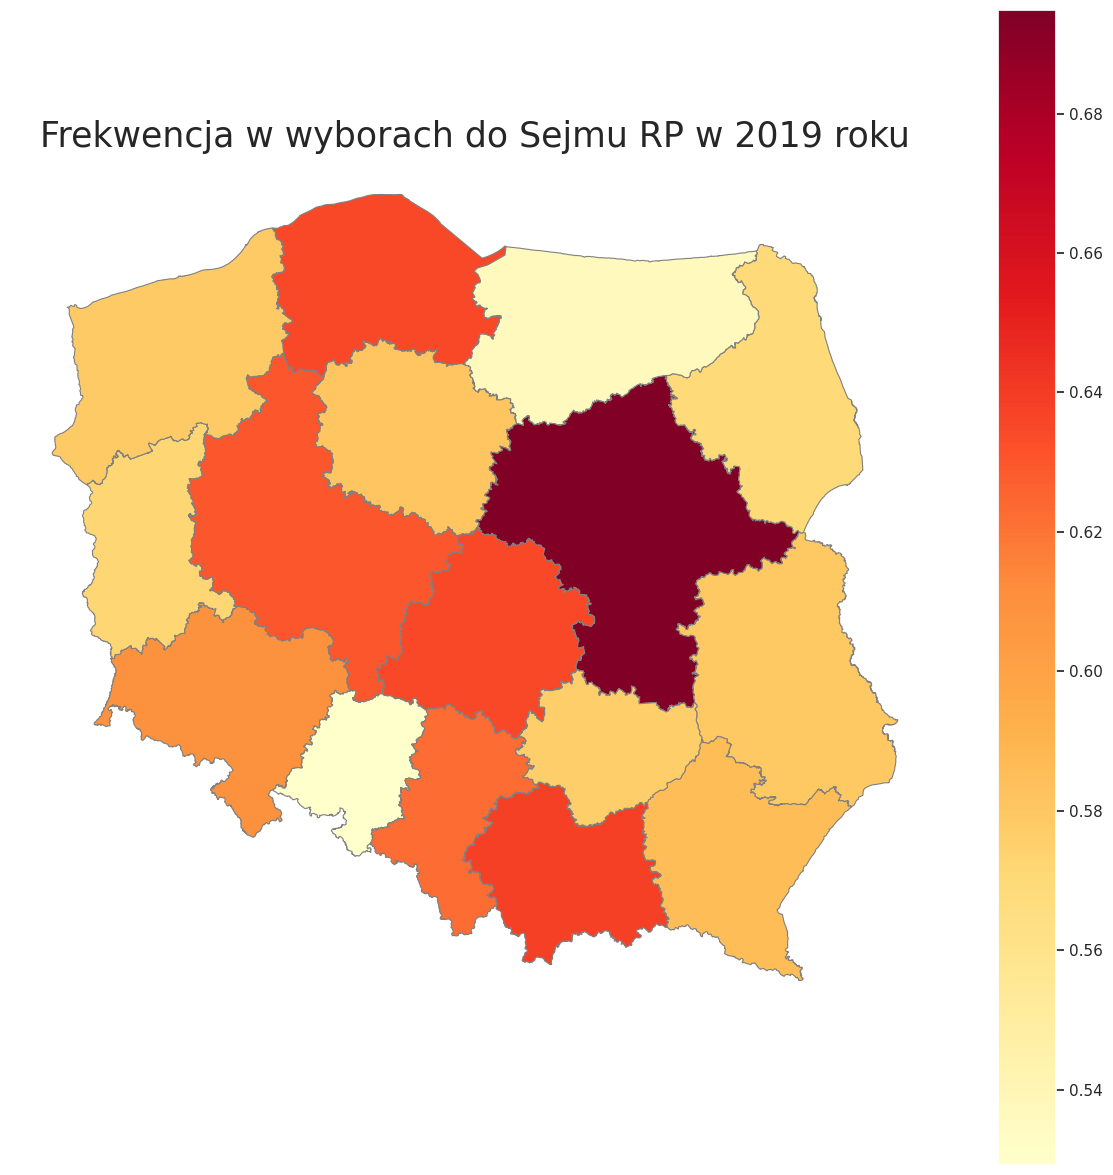

In [15]:
# połączenie tabeli z wynikiami z tabelą z konturami województw
dane_mapa_woj = pd.merge(mapa_woj, frekwencja_do_mapy, how='left', left_on='JPT_KOD_JE', right_on='wojewodztwo')
# Ustalenie rozmiaru wizualizacji
fig, ax = plt.subplots(1, figsize = (15,15))
# Kreślenie mapy i dodanie legendy
dane_mapa_woj.plot(column='frekwencja', ax=ax, cmap='YlOrRd', linewidth=0.8, edgecolor='gray', legend=True)
# Usunięcie osi
ax.axis('off')
# Tytuł mapy
plt.title("Frekwencja w wyborach do Sejmu RP w 2019 roku", size = 25)
# Wyświetlenie wykresu
plt.show()

## Mapa z komisjami wyborczymi z najniższymi oraz najwyższymi frekwencjami

Utworzenie dataframe'u z wynikami frekwencji wyborczej w podziale na komisje


In [16]:
# Utworzenie dataframe'u z wynikami frekwencji wyborczej w podziale na komisje
# Zaciągnięcie pliku .csv ze wszystkimi kolumnami
frekwencja_siedziby = wyniki
# Wyciągnięcie z pliku interesujących nas kolumn
frekwencja_siedziby = frekwencja_siedziby[["Siedziba",
                                 "Liczba wyborców uprawnionych do głosowania",
                                 "Liczba wyborców, którym wydano karty do głosowania"]]
# Nadanie nowo utworzonym kolumnom nazw
frekwencja_siedziby.columns = ["siedziba", "uprawnieni", "głosy"]
# Eliminacja braków danych
frekwencja_siedziby = frekwencja_siedziby.replace("NaN", 0).replace("-",0).fillna(0)
# Konwersja ciągu znaków na typ liczbowy
frekwencja_siedziby["uprawnieni"] = pd.to_numeric(frekwencja_siedziby["uprawnieni"])
frekwencja_siedziby["głosy"] = pd.to_numeric(frekwencja_siedziby["głosy"])
frekwencja_siedziby = frekwencja_siedziby.groupby("siedziba").sum()
# Grupowanie wyników i wyliczenie z nich sumy
frekwencja_siedziby["frekwencja"] = frekwencja_siedziby["głosy"]/frekwencja_siedziby[ "uprawnieni"]
# Eliminacja z dataframe'a komisji gdzie nikt nie może głosować
frekwencja_siedziby = frekwencja_siedziby[frekwencja_siedziby.uprawnieni != 0]
# Dodanie kolumny z frekwencją procentową i nadanie jej odpowiedniego formatu
frekwencja_siedziby["frekwencja procentowo"] = frekwencja_siedziby["frekwencja"].map('{:.2%}'.format)

frekwencja_siedziby.head()

<ipython-input-16-4bbf7f3b16da>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frekwencja_siedziby["frekwencja procentowo"] = frekwencja_siedziby["frekwencja"].map('{:.2%}'.format)


,uprawnieni,głosy,frekwencja,frekwencja procentowo
siedziba,,,,
"""AQUA"" S. A. Oczyszczalnia Ścieków, ul. Bestwińska 63, 43-300 Bielsko-Biała",2298,1619,0.704526,70.45%
"""Acherówka"", ul. W. Sławka 2, 02-495 Warszawa",2110,1621,0.768246,76.82%
"""Aqua Żyrardów"", ul. Rotmistrza Witolda Pileckiego 25/27, 96-300 Żyrardów",1270,903,0.711024,71.10%
"""Archetti"" Orkiestra Kameralna Miasta Jaworzna, ul. Wiosny Ludów 1, 43-600 Jaworzno",2336,1594,0.682363,68.24%
"""BUM-MED"" Sp. z o. o, ul. Radoszowska 163, 41-707 Ruda Śląska",1787,1187,0.664242,66.42%


Stworzenie dataframe'u z pięcioma komisjami z najwyższą frekwencją wyborczą


In [17]:
frekwencja_max = frekwencja_siedziby.sort_values(by=['frekwencja procentowo'], ascending=False) # posortowanie istniejącego dataframe'a MALEJĄCO
frekwencja_max = frekwencja_max.head(5) # 5 najlepszych wyników
frekwencja_max

,uprawnieni,głosy,frekwencja,frekwencja procentowo
siedziba,,,,
"Sanatorium Uzdrowiskowe ""Ciche Wąwozy"", Bartosza Głowackiego 12, 24-150 Nałęczów",80,79,0.987500,98.75%
"Nur-Sułtan, Ambasada RP Saryarka 15, Business Center „Isker” 010000 Nur-Sułtan, Nur-Sułtan, Republika Kazachstanu",76,75,0.986842,98.68%
"Samodzielny Publiczny Zakład Opieki Zdrowotnej, ul. gen. Władysława Sikorskiego 40, 16-100 Sokółka",65,64,0.984615,98.46%
"Ambasada RP Kichik Gala 2 Icheri Sheher (Stare Miasto) AZ - 1000, Baku, Baku, Republika Azerbejdżanu",63,62,0.984127,98.41%
BALTIC BETA,60,59,0.983333,98.33%


Stworzenie dataframe'a z pięcioma komisjami na najniższą frekwencją


In [18]:
# Posortowanie istniejącego dataframe'a ROSNĄCO
frekwencja_min = frekwencja_siedziby.sort_values(by=['frekwencja procentowo'])
frekwencja_min = frekwencja_min.head(5)
# 4 komisje w całym pliku mają frekwencję 0%
frekwencja_min

,uprawnieni,głosy,frekwencja,frekwencja procentowo
siedziba,,,,
"Izerskie Centrum Pulmonologii i Chemioterapii „Izer-Med” Sp. z o. o., ul. Szpitalna 1, 58-580 Szklarska Poręba",29,0,0.000000,0.00%
"Miejskie Centrum Medyczne im. dr. Karola Jonschera w Łodzi, ul. Przyrodnicza 7/9, 91-480 Łódź",2,0,0.000000,0.00%
"Świetlica szpitalna, Szpitalna 9, 24-300 Opole Lubelskie",32,0,0.000000,0.00%
"Zakład Opiekuńczo Leczniczy w Łęczycy, ul. Lotnicza 2A, 99-100 Łęczyca",28,0,0.000000,0.00%
"Zespół Zakładów Opieki Zdrowotnej w Dobrym Mieście, ul. Grunwaldzka 10 B, 11-040 Dobre Miasto",68,1,0.014706,1.47%


Pokazanie mapy świata z zaznaczonymi komisjami w których frekwencja była najwyższa i najniższa. Mapę można dowolnie przesuwać i przybliżać. Po kliknięciu na znaczniik wyświetla się nazwa miejsca i frekwencja wyborcza w nim.

In [19]:
# Utworzenie dataframe'u z lokalizacjami wykazanych wcześniej miejsc
lokacje_max = pd.DataFrame({
    'Nazwa miejsca':['Sanatorium Uzdrowiskowe "Ciche Wąwozy", Bartosza Głowackiego 12, 24-150 Nałęczów',
                    'Nur-Sułtan, Ambasada RP Saryarka 15, Business Center „Isker” 010000 Nur-Sułtan, Nur-Sułtan, Republika Kazachstanu',
                    'Samodzielny Publiczny Zakład Opieki Zdrowotnej, ul. gen. Władysława Sikorskiego 40, 16-100 Sokółka',
                    'Ambasada RP Kichik Gala 2 Icheri Sheher (Stare Miasto) AZ - 1000, Baku, Baku, Republika Azerbejdżanu',
                    'Platforma wiertnicza BALTIC BETA'],
    'latitude':[51.293505,51.168688,53.406556,40.362688,55.236243], # długość geograficzna
    'longitude':[22.200170,71.407987,23.485084,49.833648,18.317240]  }) # szerokość geograficzna

# Ta pętla powoduje że po kliknięciu w znacznik oprócz nazwy miejsca wyświetla się też frekwencja w nim
for i in range(0,len(lokacje_max)):
  lokacje_max['Nazwa miejsca'][i] = lokacje_max['Nazwa miejsca'][i] + ' - ' + frekwencja_max['frekwencja procentowo'][i]

# analogicznie jw.
lokacje_min = pd.DataFrame({
    'Nazwa miejsca':['Izerskie Centrum Pulmonologii i Chemioterapii „Izer-Med” Sp. z o. o., ul. Szpitalna 1, 58-580 Szklarska Poręba',
                    'Miejskie Centrum Medyczne im. dr. Karola Jonschera w Łodzi, ul. Przyrodnicza 7/9, 91-480 Łódź',
                    'Świetlica szpitalna, Szpitalna 9, 24-300 Opole Lubelskie',
                    'Zakład Opiekuńczo Leczniczy w Łęczycy, ul. Lotnicza 2A, 99-100 Łęczyca',
                    'Zespół Zakładów Opieki Zdrowotnej w Dobrym Mieście, ul. Grunwaldzka 10 B, 11-040 Dobre Miasto'],
    'latitude':[50.846475,51.801326,51.151539,52.050281,53.984815],
    'longitude':[15.548286,19.453817,21.975497,19.488420,20.4011731]  })

for i in range(0,len(lokacje_min)):
  lokacje_min['Nazwa miejsca'][i] = lokacje_min['Nazwa miejsca'][i] + ' - ' + frekwencja_min['frekwencja procentowo'][i]

# Utworzenie pustej mapy o pozycji startowej mniej-więcej na terytorium Polski i odpowiednim przybliżeniu
mapa = folium.Map(location=[52,19],zoom_start=3)

# Dodanie znaczników lokacje_max do mapy
for i, row in lokacje_max.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=row["Nazwa miejsca"], icon=folium.Icon(color='green', icon='glyphicon glyphicon-thumbs-up')).add_to(mapa)

# Dodanie znaczników lokacje_min do mapy
for i, row in lokacje_min.iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=row["Nazwa miejsca"], icon=folium.Icon(color='red', icon='glyphicon glyphicon-thumbs-down')).add_to(mapa)

mapa

<ipython-input-19-c69b4a04e9e2>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lokacje_max['Nazwa miejsca'][i] = lokacje_max['Nazwa miejsca'][i] + ' - ' + frekwencja_max['frekwencja procentowo'][i]
<ipython-input-19-c69b4a04e9e2>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lokacje_min['Nazwa miejsca'][i] = lokacje_min['Nazwa miejsca'][i] + ' - ' + frekwencja_min['frekwencja procentowo'][i]


## Wykres kołowy i słupkowy z wynikami komitetów wyborczych

In [20]:
wyniki_komitetow = wyniki
# Wybranie interesujących nas kolumn z wynikami komitetów
wyniki_komitetow = wyniki_komitetow.iloc[:,[32,33,34,35,36,37,38,39,40,41]]
# Nadanie nazw kolumnom na łatwiejsze
wyniki_komitetow.columns = ['KO', 'Emeryci', 'Konf', 'PSL', 'Prawica', 'PiS', 'Skuteczni', 'SLD', 'BiS', 'MN']
# Eliminacja braków danych
wyniki_komitetow = wyniki_komitetow.replace("NaN", 0).replace("-",0).fillna(0)
# Konwersja ciągu znaków na typ liczbowy
wyniki_komitetow = wyniki_komitetow.apply(pd.to_numeric)
# Zsumowanie głosów dla poszczególnych komitetów
wyniki_komitetow = wyniki_komitetow.sum(axis=0)
# Zresetowanie indeksu
wyniki_komitetow = pd.DataFrame(wyniki_komitetow).reset_index()
# Nowe nazwy kolumn
wyniki_komitetow.columns = ['komitet', 'głosy']
# Posortowanie wyników
wyniki_komitetow = wyniki_komitetow.sort_values('głosy', ascending=False)
# Policzenie procentów
wyniki_komitetow["procent"] = (wyniki_komitetow['głosy'] / wyniki_komitetow['głosy'].sum()) * 100

# Utworzenie osobno tabeli dla komitetów, które nie uzyskały progu 5%
wyniki_inne = wyniki_komitetow[wyniki_komitetow["głosy"] < 0.05*wyniki_komitetow["głosy"].sum()]
# Zaokrąglenie
wyniki_inne["procent"] = round(wyniki_inne["procent"], 3)
# Ponowne ustanowienie indeksu
wyniki_inne = wyniki_inne.reindex(index=wyniki_inne.index[::-1])

print(wyniki_inne)

# Utworzenie osobno wartości dla sumy wyników komitetów, które nie osiągnęły progu 5%
wyniki_komitetow = wyniki_komitetow[wyniki_komitetow["głosy"] > 0.05*wyniki_komitetow["głosy"].sum()]
wyniki_komitetow = wyniki_komitetow.append({"komitet" : "Pozostałe", "głosy" : wyniki_inne["głosy"].sum(), "procent" : wyniki_inne["procent"].sum()}, ignore_index=True)
wyniki_komitetow["procent"] = round(wyniki_komitetow["procent"], 2)
# Przydzielenie kolorów dla komitetów
kolory = ['darkblue', 'orange','red','green','black','sienna']
wyniki_komitetow["kolory"] = kolory

print(wyniki_komitetow)

     komitet     głosy  procent
4    Prawica    1765.0    0.010
1    Emeryci    5448.0    0.029
6  Skuteczni   18918.0    0.102
9         MN   32094.0    0.174
8        BiS  144773.0    0.784
     komitet      głosy  procent    kolory
0        PiS  8051449.0    43.59  darkblue
1         KO  5060246.0    27.40    orange
2        SLD  2319865.0    12.56       red
3        PSL  1578471.0     8.55     green
4       Konf  1256880.0     6.81     black
5  Pozostałe   202998.0     1.10    sienna


<ipython-input-20-ea5ce3fd8743>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wyniki_inne["procent"] = round(wyniki_inne["procent"], 3)
<ipython-input-20-ea5ce3fd8743>:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wyniki_komitetow = wyniki_komitetow.append({"komitet" : "Pozostałe", "głosy" : wyniki_inne["głosy"].sum(), "procent" : wyniki_inne["procent"].sum()}, ignore_index=True)


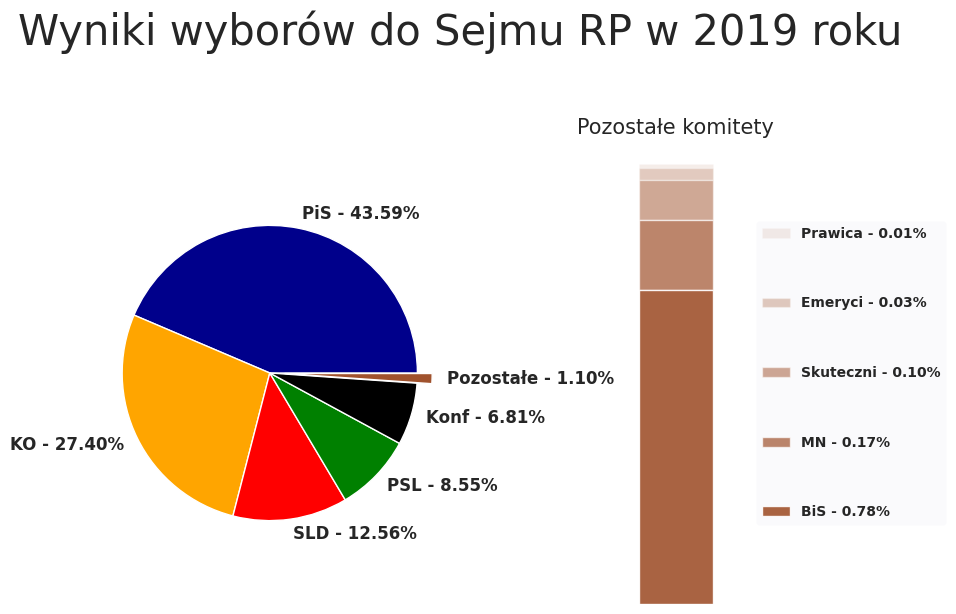

In [21]:
# Utworzenie wykresu i przypisanie osi
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
fig.subplots_adjust(wspace=0.1)
# Tytuł wykresu
fig.suptitle('Wyniki wyborów do Sejmu RP w 2019 roku', fontsize=30, y=1.1)

# Funkcja formatująca liczby na procenty
def Ratios_to_labels(labels, ratios):
  for i in range(len(labels)):
    labels[i] = labels[i] + ' - ' + f'{ratios[i]:,.2f}%'
  return labels

# Parametry wykresu kołowego
overall_ratios = wyniki_komitetow["procent"].reset_index(drop=True)
labels_pie = wyniki_komitetow["komitet"].reset_index(drop=True)
kolory = wyniki_komitetow["kolory"].reset_index(drop=True)

Ratios_to_labels(labels_pie, overall_ratios)

# Wysunięcie kawałka z innymi komitetami
explode = [0,0,0,0,0,0.1]

# Odwrócenie wykresu
angle = 0 * overall_ratios[0]

# Utworzenie wykresu kołowego
wedges, *_ = ax1.pie(overall_ratios,  startangle=angle,
                     labels=labels_pie, explode = explode,
                     colors=kolory, textprops={'fontsize': 12, "weight" : 'bold'})

# Parametry wykresu słupkowego
inne_ratios = wyniki_inne["procent"].reset_index(drop=True)
inne_labels = wyniki_inne["komitet"].reset_index(drop=True)
bottom = 1
width = .2

Ratios_to_labels(inne_labels, inne_ratios)

# Tożsamość kolorów na wykresie słupkowym z kolorami na legendzie
for j, (height, label) in enumerate([*zip(inne_ratios, inne_labels)]):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='sienna', label=label,
                 alpha=0.1 + 0.2 * j)

# Parametry wykresu c.d.
ax2.set_title('Pozostałe komitety', fontsize = 15)
ax2.legend(labels = inne_labels,
           loc = 'center left',
           bbox_to_anchor=(0.7,0.5),
           labelspacing = 4,
           prop = {'size' : 10, 'weight' : "bold"},
           framealpha=0.2,
           edgecolor = 'white')
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

plt.show() # Pokazanie wykresu

## Wykres mapowy z zwycięskimi komitetami w gminach

In [32]:
wyniki_gmina = wyniki
# Wybranie potrzebnych kolumn
wyniki_gmina = wyniki_gmina.iloc[:,[1,32,33,34,35,36,37,38,39,40,41]]
# Nadanie nowych nazw kolumnom
wyniki_gmina.columns = ['teryt','KO', 'Emeryci', 'Konf', 'PSL', 'Prawica', 'PiS', 'Skuteczni', 'SLD', 'BiS', 'MN']
# Eliminacja braków danych i danych nieliczbowych
wyniki_gmina = wyniki_gmina.replace("NaN", 0).replace("-",0).fillna(0)
# Przekształcenie danych w wartości numeryczne
wyniki_gmina[['KO', 'Emeryci', 'Konf', 'PSL', 'Prawica', 'PiS', 'Skuteczni', 'SLD', 'BiS', 'MN']] = wyniki_gmina[['KO', 'Emeryci', 'Konf', 'PSL', 'Prawica', 'PiS', 'Skuteczni', 'SLD', 'BiS', 'MN']].apply(pd.to_numeric)
# Zsumowanie danych według gmin
wyniki_gmina = wyniki_gmina.groupby('teryt').sum()
# Utworzenie kolumny z nazwą zwycięskiego komietu w danej gminie
wyniki_gmina["zwycięzca"] = wyniki_gmina.apply(lambda x: x.idxmax(), axis=1)

# Sprawdzenie kto wygrał w jakiej ilości gmin
print(wyniki_gmina["zwycięzca"].value_counts())

# Skasowanie niepotrzebnych już kolumn z wynikami dla poszczególnych komitetów
wyniki_gmina = wyniki_gmina.drop(columns = ['KO', 'Emeryci', 'Konf', 'PSL', 'Prawica', 'PiS', 'Skuteczni', 'SLD', 'BiS', 'MN'])
# Zresetowanie indeksu
wyniki_gmina = wyniki_gmina.reset_index()

wyniki_gmina

PiS    2293
KO      193
MN       10
PSL       1
Name: zwycięzca, dtype: int64


,teryt,zwycięzca
0,0,KO
1,020101,PiS
2,020102,PiS
3,020103,PiS
4,020104,PiS
...,...,...
2492,321804,PiS
2493,321805,PiS
2494,326101,KO
2495,326201,KO


In [33]:
# Wczytanie pliku shapefile z Dysku Google
mapa_gminy = gminy
# Zmiana nazwy kolumny z kodem TERYT na pasującą do tabeli wyniki_gmina
mapa_gminy = mapa_gminy.rename(columns={'JPT_KOD_JE':'teryt'})
# Wybranie potrzebnych do wykresów kolumn
mapa_gminy = mapa_gminy[['teryt', 'geometry']]
# Przekształcenie wartości kodu TERYT na string. Dzięki temu nie tracimy cyfry 0 na początku kodu
mapa_gminy['teryt'] = mapa_gminy['teryt'].astype(str)
# Odcięcie niepotrzebnej na potrzeby wykresu ostatniej cyfry w kodzie TERYT
mapa_gminy['teryt'] = mapa_gminy['teryt'].str[:-1]
# Połączenie z tabelą wyniki_gmina
mapa_gminy = pd.merge(mapa_gminy, wyniki_gmina, how='left', left_on='teryt', right_on='teryt')

mapa_gminy

,teryt,geometry,zwycięzca
0,321501,"POLYGON ((348589.869 646387.773, 348586.260 64...",KO
1,061907,"POLYGON ((822697.514 387738.756, 822671.790 38...",PiS
2,221402,"POLYGON ((481876.019 646587.584, 481847.800 64...",PiS
3,221403,"POLYGON ((476330.818 656086.601, 476319.846 65...",PiS
4,140606,"POLYGON ((637553.954 431787.079, 637531.922 43...",PiS
...,...,...,...
2472,281509,"POLYGON ((551343.849 642379.975, 551394.274 64...",PiS
2473,261202,"POLYGON ((654867.026 275893.533, 654657.397 27...",PiS
2474,140706,"POLYGON ((663892.899 426979.325, 663887.858 42...",PiS
2475,320704,"POLYGON ((211492.333 689173.792, 211648.350 68...",KO


Utworzenie wykresu z wykorzystaniem pakietu matplotlib i geopandas.

Należy zaznaczyć, że ze względu na specyficzną złożoność podziału administracyjnego Warszawy (podział na dzielnice), wykres nie uwzględnia zwycięzcy w tym mieście. Wygranym komitetem w Warszawie był KKW Koalicja Obywatelska PO .N iPL Zieloni - KO.

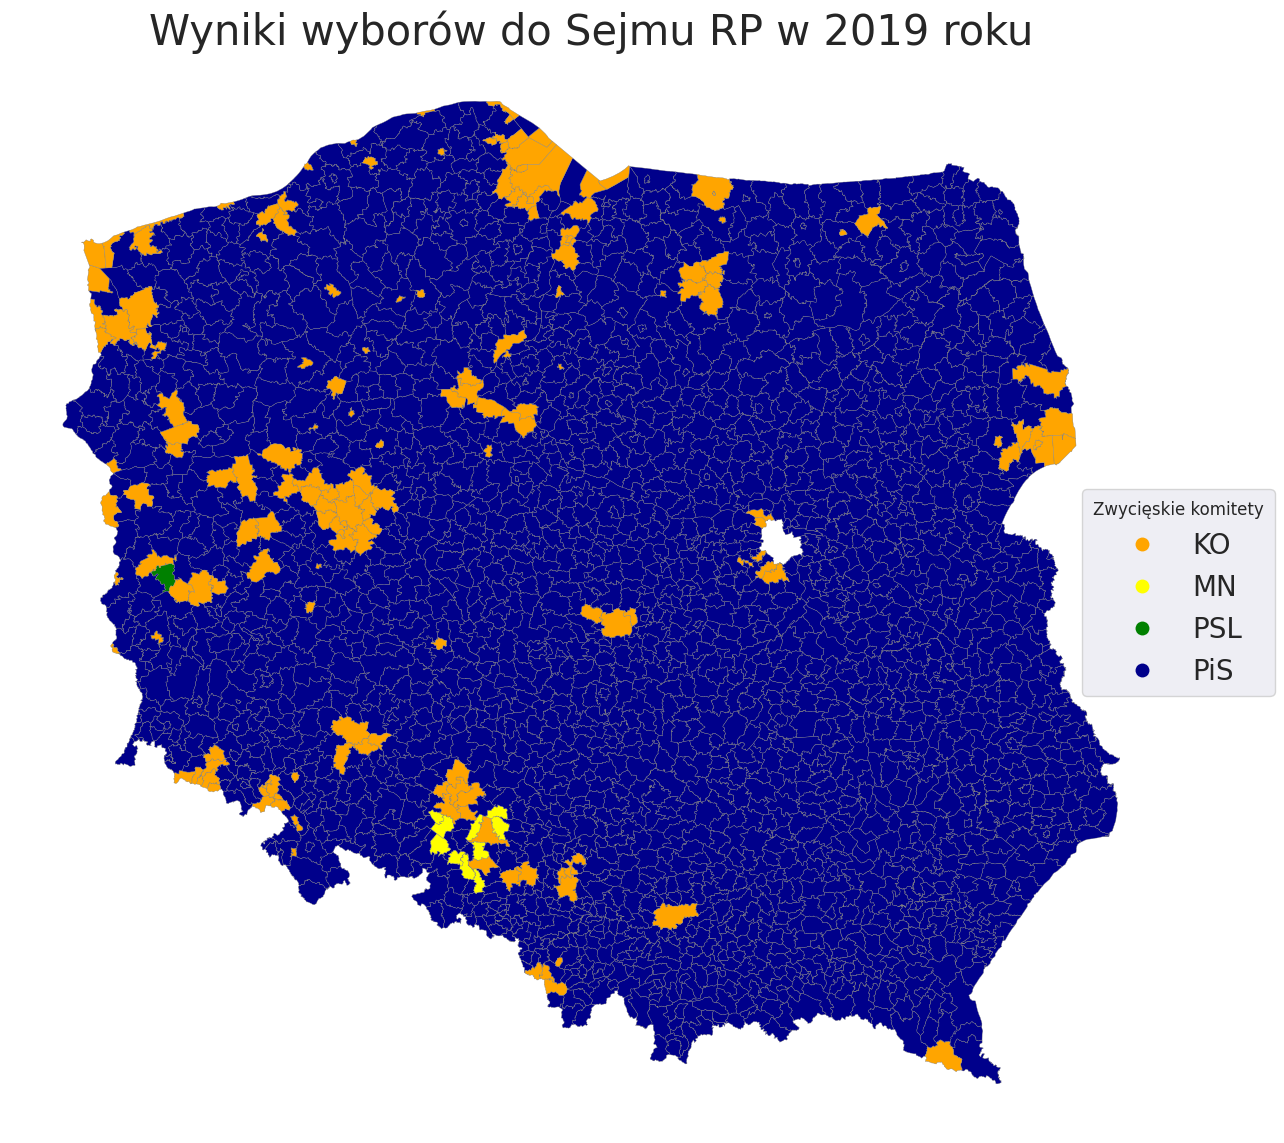

In [34]:
# Ustalenie rozmiaru wizualizacji
fig, ax = plt.subplots(1, figsize = (15,15))

# Kreślenie mapy i dodanie legendy
mapa_gminy.plot(column='zwycięzca',
                ax=ax,
                # Dobranie własnych kolorów charekteryzujące komitety
                cmap =  ListedColormap(["orange", "yellow", "green", "darkblue"]),
                # grubość granic gmin
                linewidth=0.25,
                edgecolor='grey',
                legend = True,
                # Ustawienia legendy
                legend_kwds={'loc': 'center right', 'bbox_to_anchor':(1.1,0.5), 'fontsize': 20, 'title' : "Zwycięskie komitety"}
                )
# Usunięcie osi
ax.axis('off')

# Tytuł mapy
plt.title("Wyniki wyborów do Sejmu RP w 2019 roku", size = 30)
# Ukazanie wizualizacji
plt.show()


## Wykres słupkowy z podziałem głosów wg. wieku


Wykres powstanie na podstawie danych uzyskanych z sondażu exit polls z dnia wyborów do Sejmu RP w 2019 roku.

In [25]:
# Wczytanie pliku z frekwencją wyborczą według wieku
wedlug_wieku = frekwencja_według_wieku
# Nazwanie kolumn wczytanej tabeli
wedlug_wieku.columns = ['wiek','frekwencja']

wedlug_wieku

,wiek,frekwencja
0,18-29,0.464
1,30-39,0.603
2,40-49,0.757
3,50-59,0.596
4,60-,0.662


In [26]:
# Utworzenie funkcji dodającej obrazki do wykresu
def image_plot(heights, images, spacing=0):
  # Iterowanie przez dane i obrazy, autoskalowanie szerokości wykresu dostosowując go do obrazków
    for i, (height, img) in enumerate(zip(heights, images)):
        AR = img.shape[1] / img.shape[0]
        left = AR*i + spacing*i
        right = left + AR
        plt.imshow(img, extent=[left, right, 0, height])

    # Ustawienie granic osi x, y na wykresie
    plt.xlim(0, right)
    plt.ylim(0, max(heights)*1.1)

    x = [0.35, 1.1, 1.8, 2.5, 3.5]
    # Podpisanie osi x
    plt.xticks(x, wedlug_wieku['wiek'], size = 15)

Wykres słupkowy z wykorzystaniem pakietu matplotlib. W miejsce klasycznych słupków wstawiamy obrazki z graficzną reprezentacją kategorii wiekowej wyborców w celu łatwiejszej analizy wykresu.

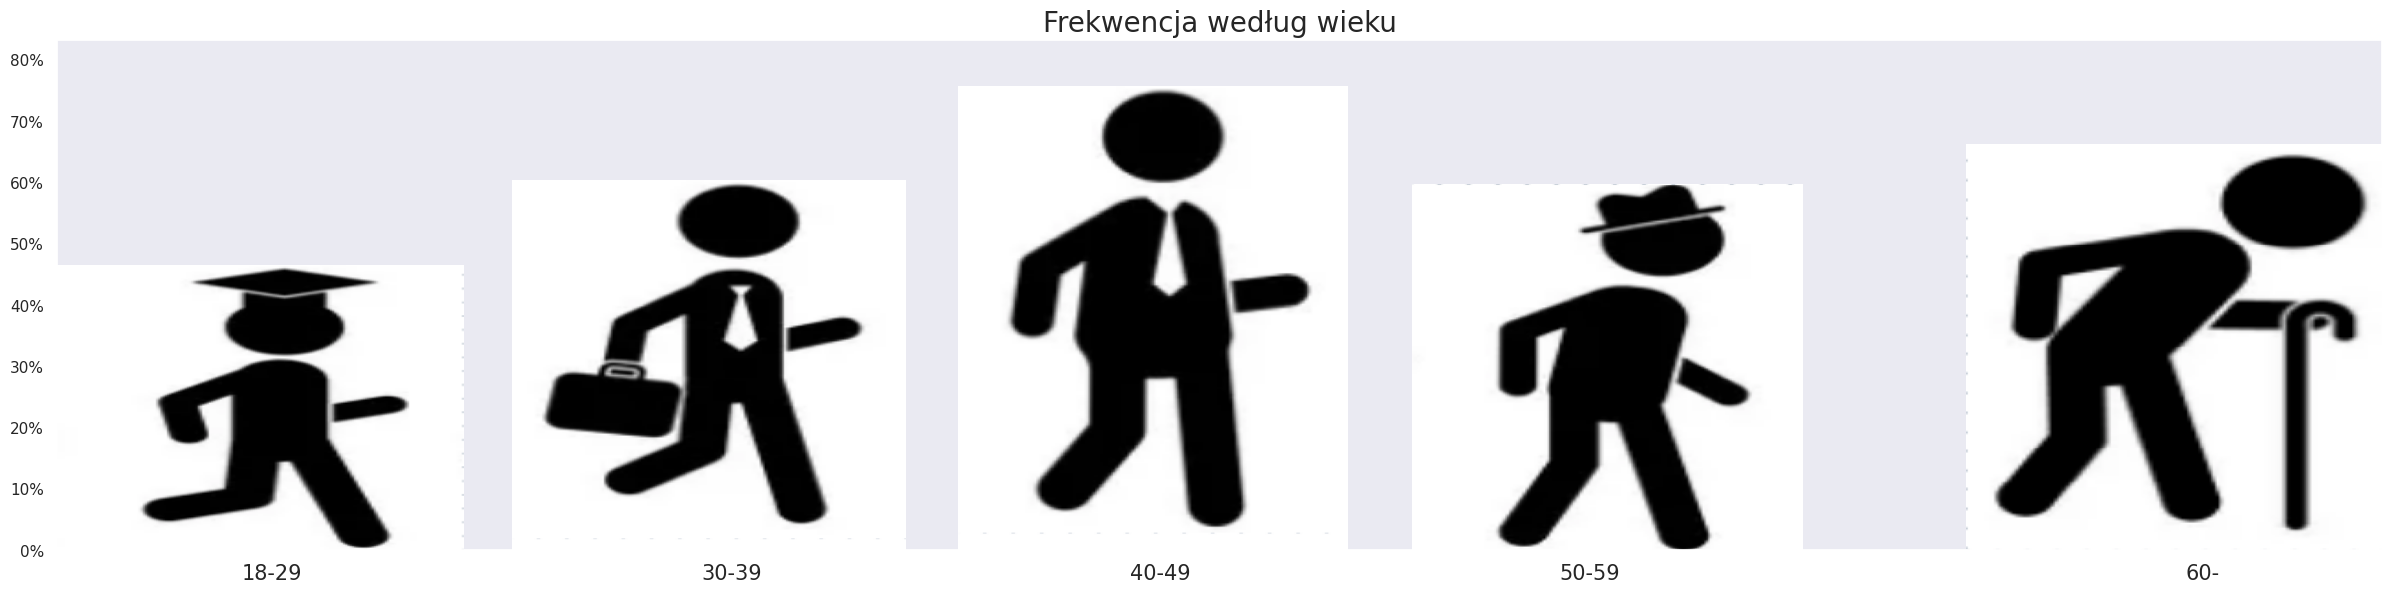

In [27]:
# Wczytanie danych o frekwencji
lata = wedlug_wieku['frekwencja']
# Przypisanie obrazów do jednej zmiennej
obrazki = [kat1,kat2,kat3,kat4,kat5]

# Utworzenie wykresu
image_plot(lata,obrazki,spacing=0.1)
# Sformatowanie osi y do wartości procentowych
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
# Tytuł wykresu
plt.title('Frekwencja według wieku', size = 20)

# Usunięcie siatki z wykresu
plt.grid(False)

## Wykres kafelkowy z podziałem mandatów w Sejmie

Podział miejsc w Sejmie jest wyliczany na podstawie metody d'Hondta na podstawie sumy głosów oddanych na poszczególne komitety wyborcze.

In [28]:
# Słownik z danymi o mandatach
dane_do_sejmu = {'PiS': 235,
                 'KO': 134,
                 'SLD': 49,
                 'PSL': 30,
                 'Konfederacja': 11,
                 'Mniejszość Niemiecka': 1}

Podział mandatów został przedstawiony za pomocą kafelków. W Sejmie mamy 460 mandatów. 1 mandat to oczywiście 1 kafelek.

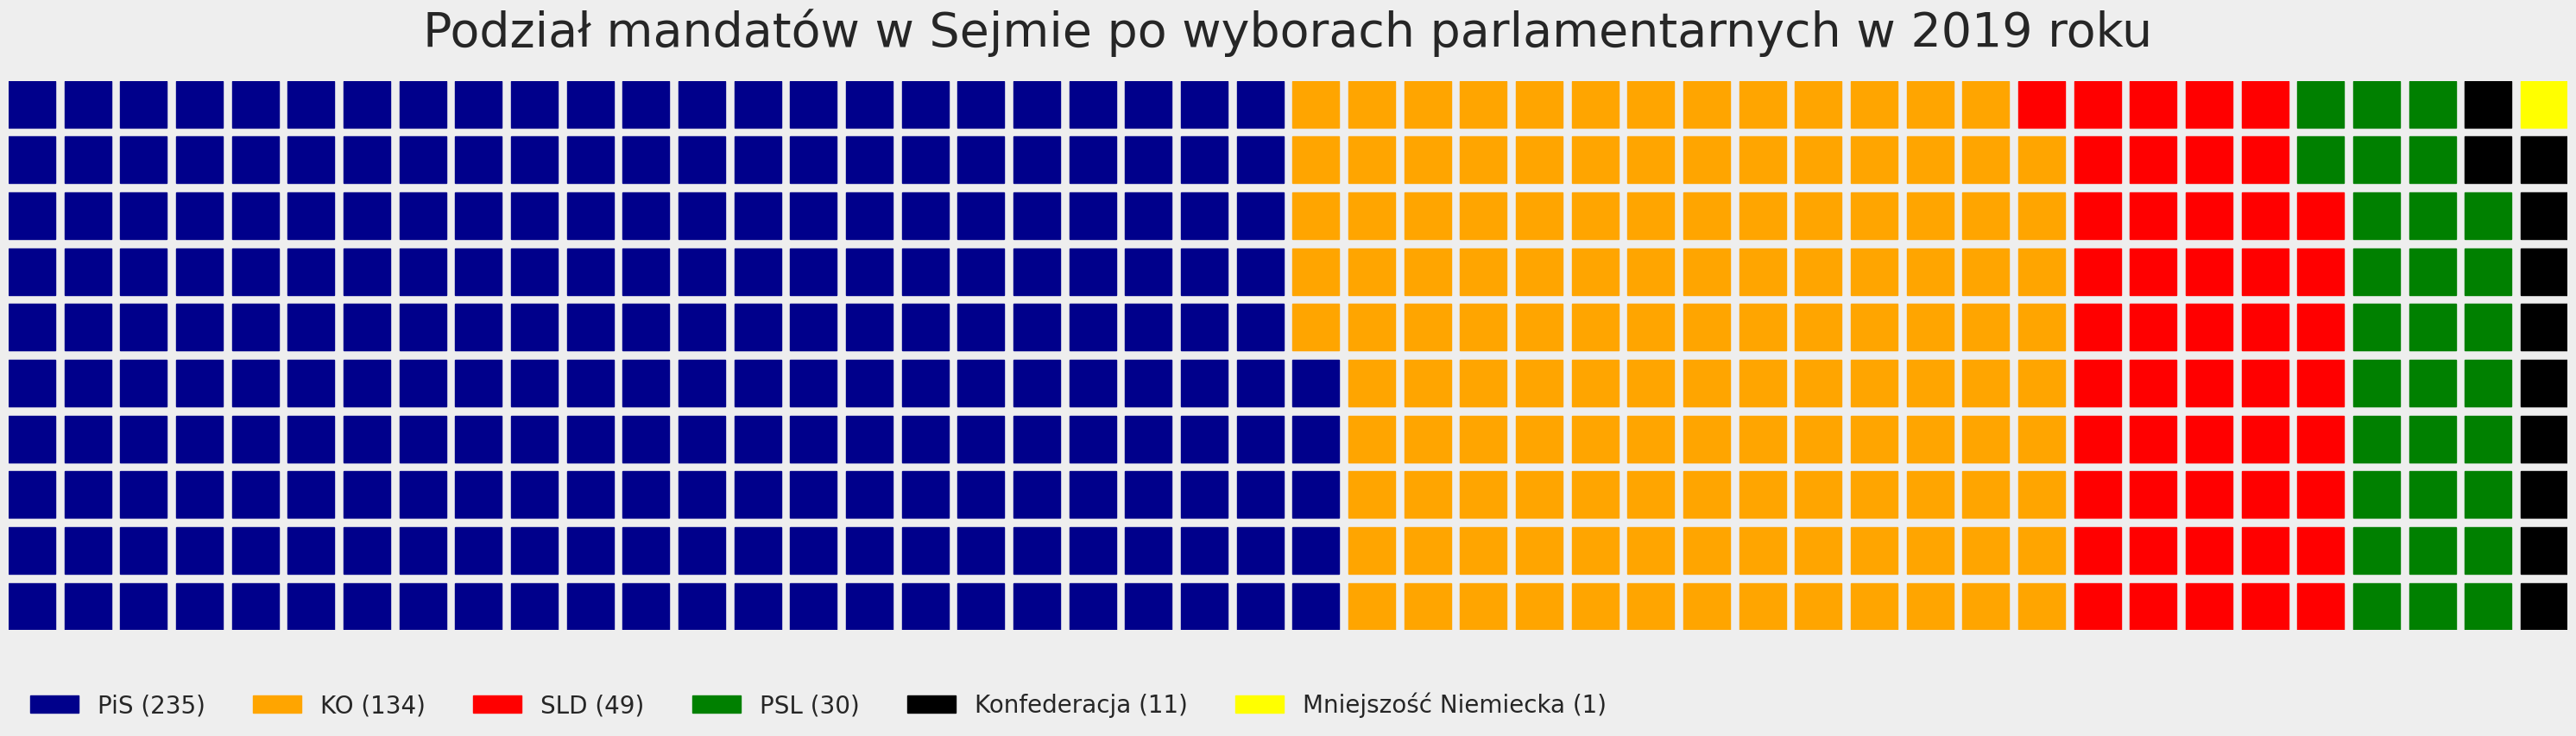

In [29]:
# Utworzenie wykresu
fig = plt.figure(
    # Wykres kafelkowy (wafelkowy :-D )
    FigureClass=Waffle,
    # Liczba wierszy w wykresie
    rows=10,
    # Pobranie danych
    values=dane_do_sejmu,
    # Ustawienie kolorów dla poszczególnych partii
    colors=("darkblue", "orange", "red", "green", "black", "yellow"),
    # Stworzenie tytułu, ustawienie go na środku wizualizacji i ustawienie jego rozmiaru
    title={'label': 'Podział mandatów w Sejmie po wyborach parlamentarnych w 2019 roku', 'loc': 'center', 'size': 40, 'y':1.05},
    # Podpisy ukazujące w nawiasie ile mandatów ma każda partia
    labels=["{0} ({1})".format(k, v) for k, v in dane_do_sejmu.items()],
    # Stworzenie i ustawienie legendy na wykresie
    legend={'loc': 'lower left', 'bbox_to_anchor': (0, -0.2), 'ncol': len(dane_do_sejmu), 'framealpha': 0, 'fontsize':20}
)
# Ustawienie kolorów tła na biały
fig.gca().set_facecolor('#EEEEEE')
fig.set_facecolor('#EEEEEE')
# Pokazanie wykresu
plt.show()